### Funnel

In [1]:
import jax
import jax.scipy.stats as jst
from jax.random import PRNGKey, normal, split
import matplotlib.pyplot as plt
import numpy as np

from kernels import kernel_factory
from utils import *
from integrators import *
from test_functions import neg_log_funnel, neg_log_nD_funnel

root_seed=12387593871
key = PRNGKey(root_seed)

U = neg_log_nD_funnel()
# U = neg_log_funnel()
dim = 20

# key, split_key = split(key)
# q_init = normal(split_key, (dim, ))
q_init = jnp.zeros(dim)
q_init = q_init.at[-1].set(10)

2023-03-21 10:04:00.270116: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 10:04:00.721257: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 10:04:00.727991: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 10:04:02.668560: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-21 10:04:02.668675: W external/org

In [2]:
num_warmup = 1000
num_samples = 20000
keys = split(key, num=num_samples+num_warmup)

### M=1

In [3]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.25

init_state, m1hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs)

carry, burned_m1hmc_states = jax.lax.scan(m1hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m1hmc_states = jax.lax.scan(m1hmc_kernel, carry, keys[num_warmup:,:])

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `bool` function. 
The error occurred while tracing the function kernel at /mnt/e/OneDrive - mytum.de/Personal/Projects/TUM_Master_thesis/master-thesis/sampling/best_mcmc/kernels.py:123 for scan. This concrete value was not available in Python because it depends on the value of the argument 'carry'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

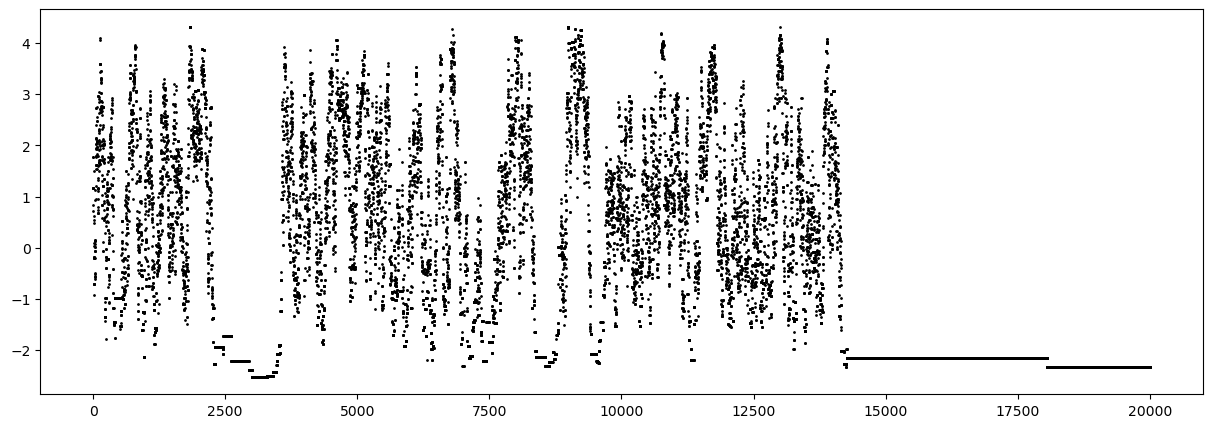

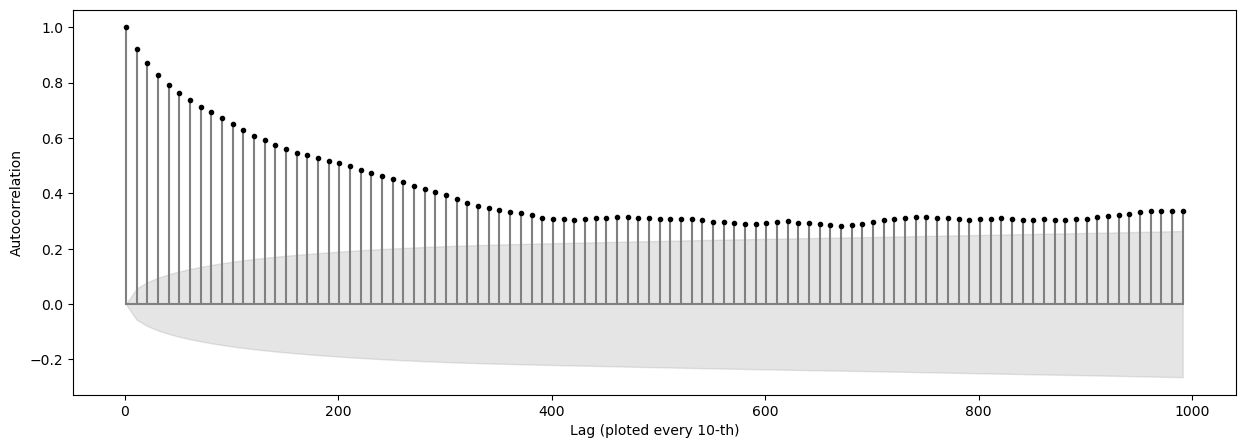

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), m1hmc_states[0][:,-1], s=1, c='k')
plot_ac(m1hmc_states[0][:,-1], lag=1000, plot_every=10)

Final step size: 0.3758610785007477
Final average acceptance rate: [0.37104434]


(-10.0, 150.0)

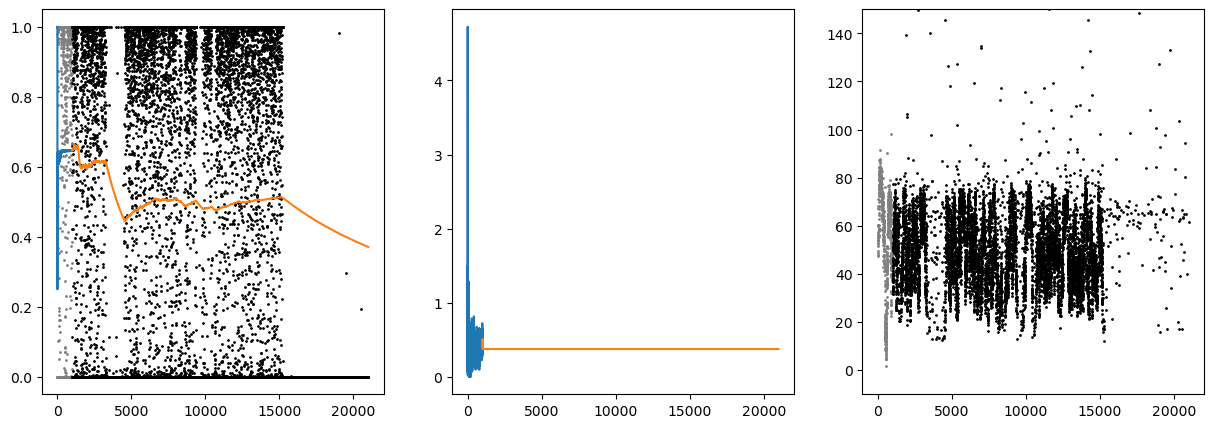

In [ ]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, m1hmc_states[i])) for i, arr in enumerate(burned_m1hmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate,_,_ = compute_stats(np.expand_dims(accept_prob, axis=1))
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')

x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')
axes[2].set_ylim(-10,150)

### M=10

In [ ]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.25

init_state, m10hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, M=10)

carry, burned_m10hmc_states = jax.lax.scan(m10hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m10hmc_states = jax.lax.scan(m10hmc_kernel, carry, keys[num_warmup:,:])

/home/dawid/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


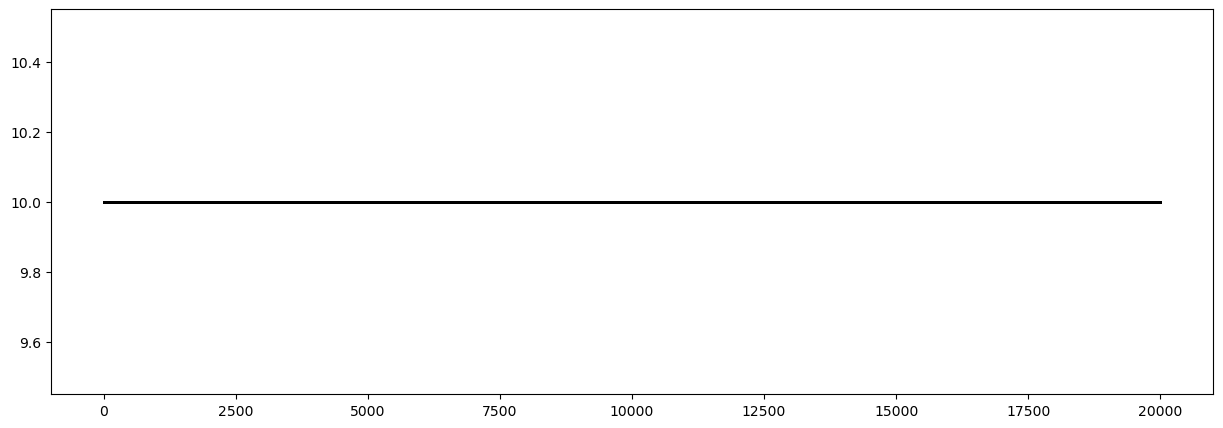

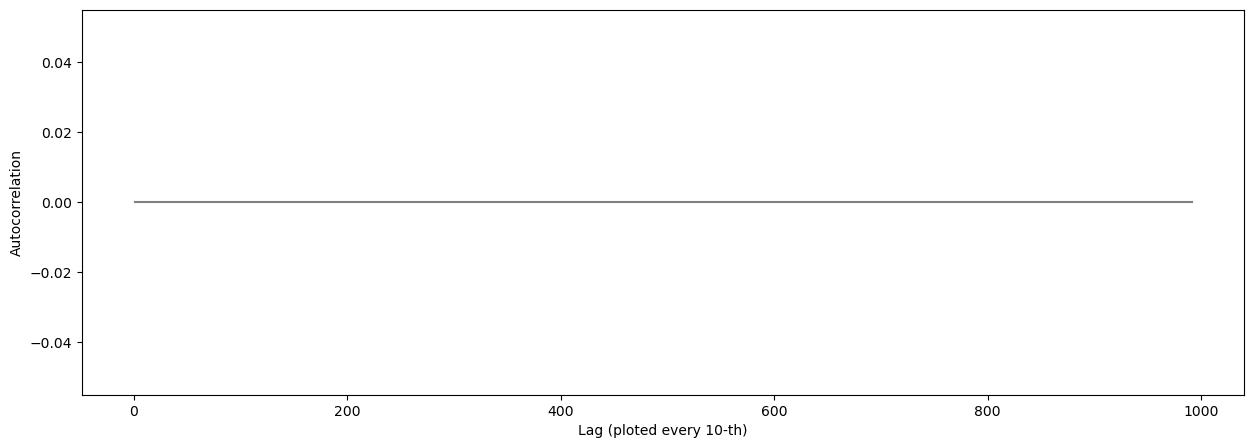

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), m10hmc_states[0][:,-1], s=1, c='k')
plot_ac(m10hmc_states[0][:,-1], lag=1000, plot_every=10)

Final step size: 0.0
Final average acceptance rate: [0.]


(-10.0, 150.0)

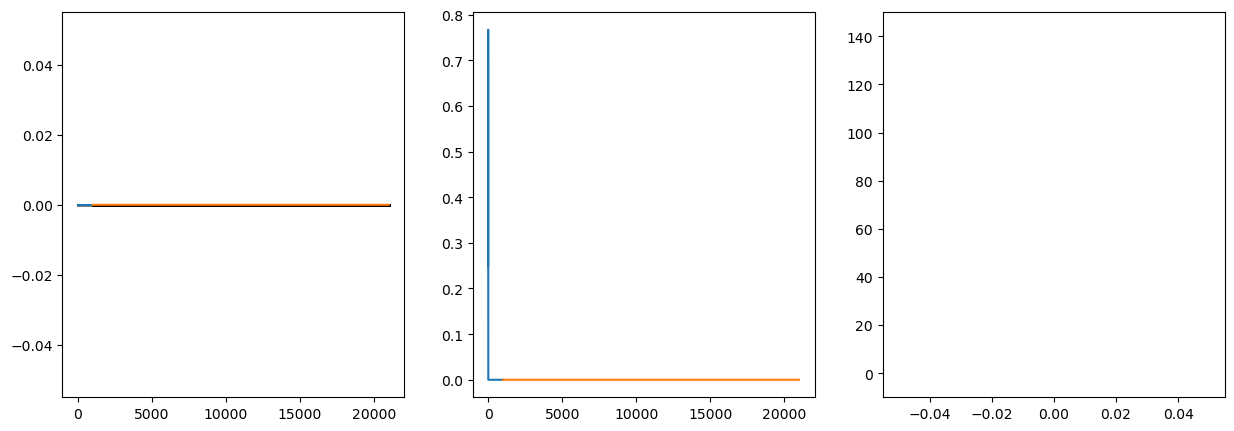

In [ ]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, m10hmc_states[i])) for i, arr in enumerate(burned_m10hmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate,_,_ = compute_stats(np.expand_dims(accept_prob, axis=1))
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

axes[2].set_ylim(-10,150)

### M=0.1

In [ ]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.25

init_state, m01hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, M=.1)

carry, burned_m01hmc_states = jax.lax.scan(m01hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m01hmc_states = jax.lax.scan(m01hmc_kernel, carry, keys[num_warmup:,:])

/home/dawid/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


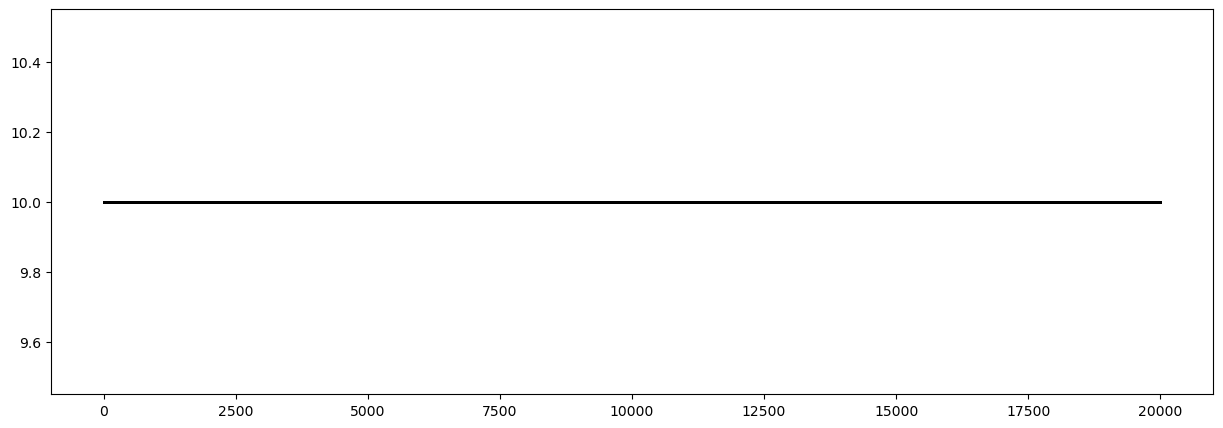

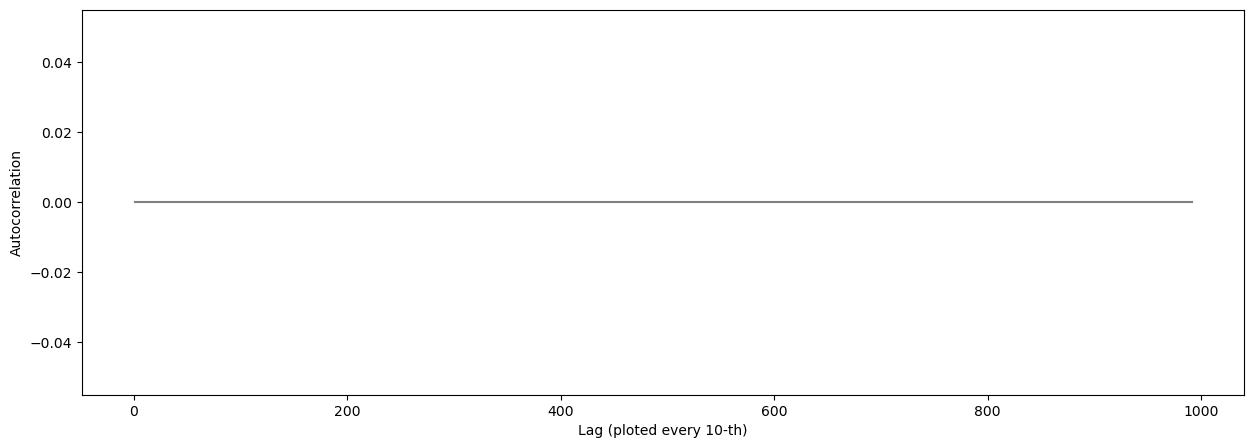

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), m01hmc_states[0][:,-1], s=1, c='k')
plot_ac(m01hmc_states[0][:,-1], lag=1000, plot_every=10)

Final step size: 0.0
Final average acceptance rate: [0.]


(-10.0, 150.0)

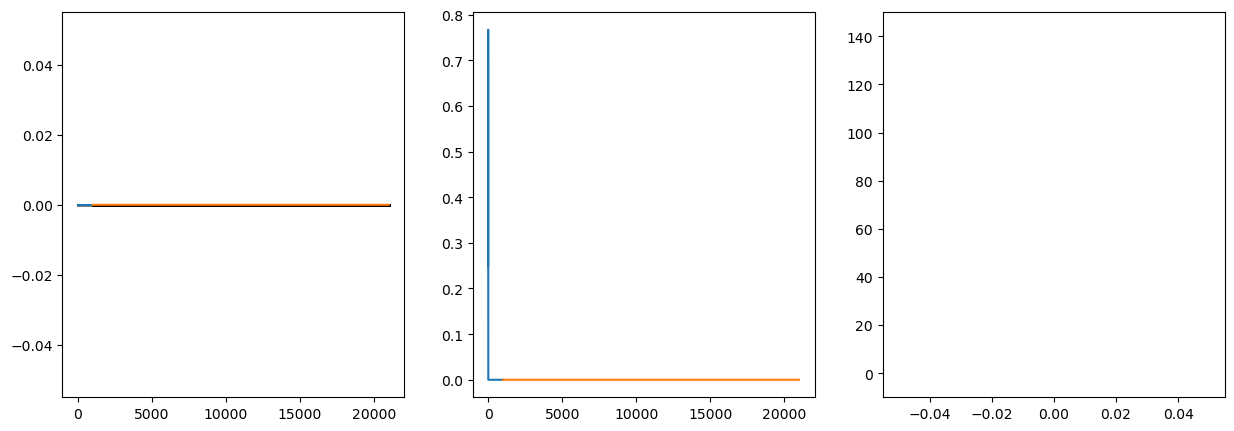

In [ ]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, m01hmc_states[i])) for i, arr in enumerate(burned_m01hmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate,_,_ = compute_stats(np.expand_dims(accept_prob, axis=1))
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

axes[2].set_ylim(-10,150)

### DiagQHMC

In [ ]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# random_mass_kwargs = {"mu":-.5, "sigma":.2}
random_mass_kwargs = {"mu":-.1, "sigma":.3} # this has rouhgly mean 1.0
# dual_avg_kwargs = None
init_step_size=.25

init_state, dqhmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, random_mass_kwargs=random_mass_kwargs)

carry, burned_dqhmc_states = jax.lax.scan(dqhmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , dqhmc_states = jax.lax.scan(dqhmc_kernel, carry, keys[num_warmup:,:])

/home/dawid/miniconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


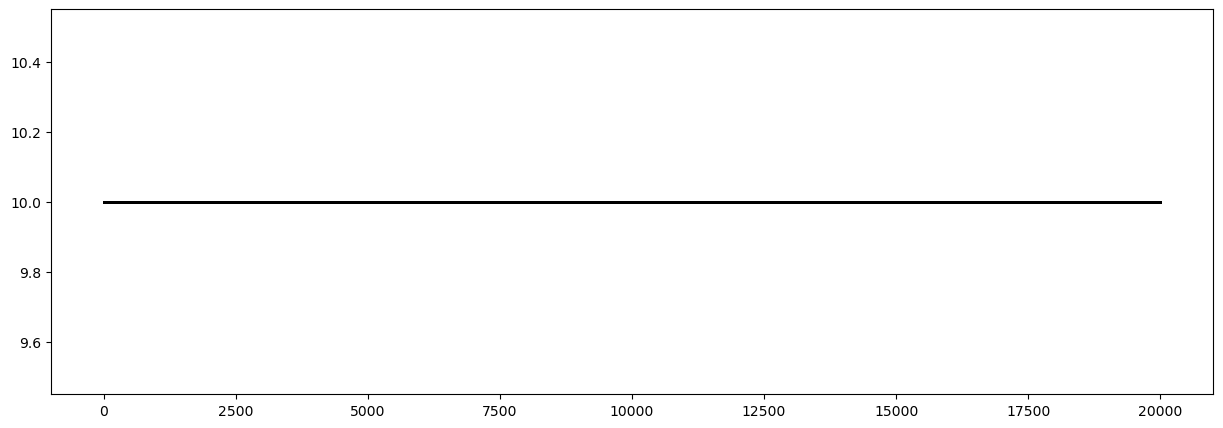

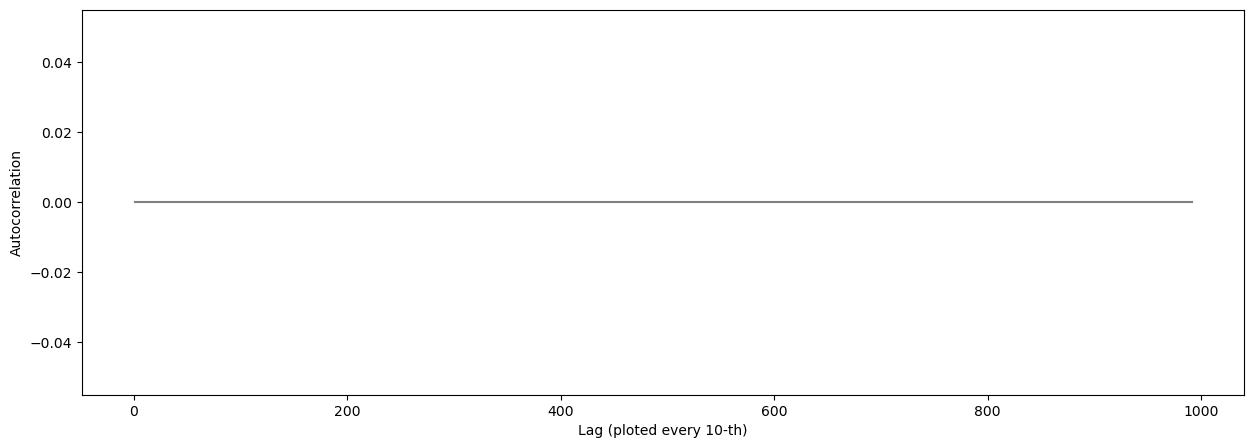

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), dqhmc_states[0][:,-1], s=1, c='k')
plot_ac(dqhmc_states[0][:,-1], lag=1000, plot_every=10)

Final step size: 0.0
Final average acceptance rate: [0.]


(-10.0, 150.0)

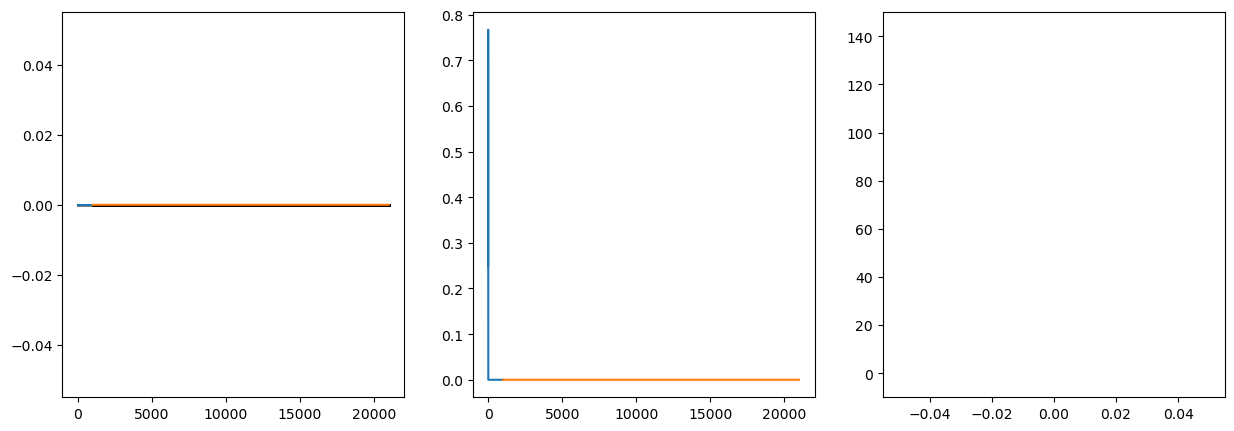

In [ ]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, dqhmc_states[i])) for i, arr in enumerate(burned_dqhmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate,_,_ = compute_stats(np.expand_dims(accept_prob, axis=1))
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

axes[2].set_ylim(-10,150)

### Result comparison

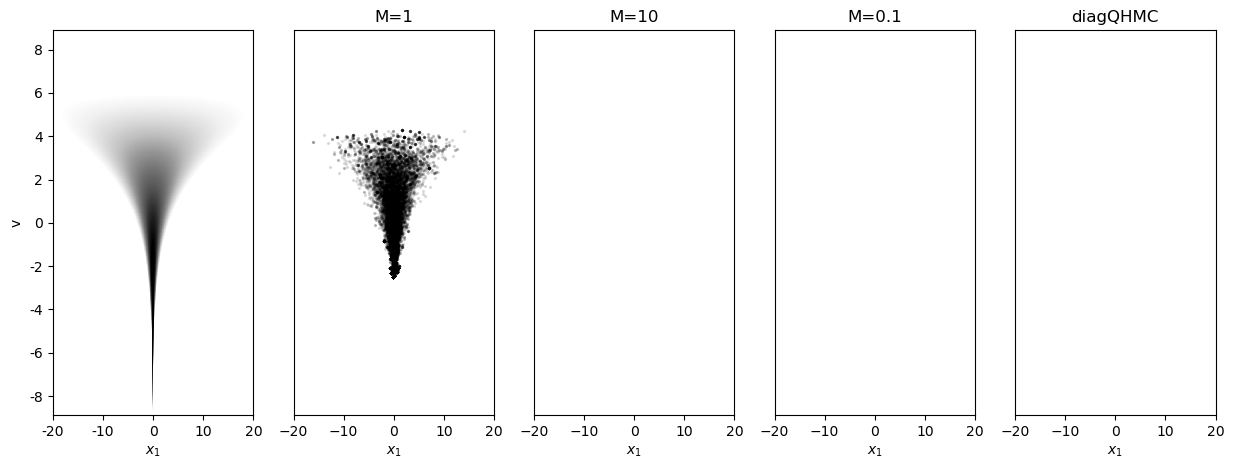

In [ ]:
U = neg_log_funnel()

x_lim = [-20, 20]
y_lim = [-9, 9]
res = 500
x, y = np.meshgrid(np.linspace(*x_lim, res), np.linspace(*y_lim, res))
pos = np.dstack((x, y))
logp = -jax.vmap(jax.vmap(U))(pos)

fig, ax = plt.subplots(1,5, figsize=(15,5))

# ax.contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
ax[0].pcolor(logp, vmin=-8, vmax=-2.5, cmap="Greys")
x_labels = [-20,-10,0,10,20]
ax[0].set_xticks(np.linspace(0,res,len(x_labels)))
ax[0].set_xticklabels(x_labels)
y_labels = np.arange(-8,9,2)
ax[0].set_yticks(25+np.linspace(0,res-50,len(y_labels)))
ax[0].set_yticklabels(y_labels)
ax[0].set_ylabel("v")
ax[0].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

ax[1].set_title("M=1")
ax[1].scatter(*m1hmc_states[0][:,-2:].T, s=2, c="k", alpha=0.1)

ax[2].set_title("M=10")
ax[2].scatter(*m10hmc_states[0][:,-2:].T, s=2, c="k", alpha=0.1)

ax[3].set_title("M=0.1")
ax[3].scatter(*m01hmc_states[0][:,-2:].T, s=2, c="k", alpha=0.1)

ax[4].set_title("diagQHMC")
ax[4].scatter(*dqhmc_states[0][:,-2:].T, s=2, c="k", alpha=0.1)

for i in range(1,5):
    ax[i].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian
    ax[i].set_xlim(*x_lim)
    ax[i].set_ylim(*y_lim)
    ax[i].set_yticks([])